# **Hand History Study**

## Objectives

* Answer **requirement 1**:
    * Investigate if hero has a positive win rate

## Inputs

* outputs/datasets/collection/0.05 - 0.1 - 6max.txt

## Outputs

* Parse data from hand history
* Plot a grapfh with heros win/loss over the sample of hands and calculate win rate

---

# Change working directory

Since jupyter notebooks are in a subfolder we need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'd:\\codeacademy_darbai\\poker_assistant\\poker-assistant-rl\\supervised_learning'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'd:\\codeacademy_darbai\\poker_assistant\\poker-assistant-rl'

# Load Data

In [ ]:
import glob

input_folder = "outputs/datasets/collection"
txt_files = glob.glob(f"{input_folder}/*.txt")
txt_files[0]

# Read the content of the first text file
with open(txt_files[0], 'r', encoding="utf-8") as file:
    content = file.read()

---

# Parse Data

* Split into individual hands

In [ ]:
import re

hand_pattern = r"Poker Hand #RC\d+: .*?(?=Poker Hand #RC\d+:|$)"
hands = re.findall(hand_pattern, content, re.DOTALL)

print(f"There is {len(hands)} of hands in the sample")

There is 12493 of hands in the sample
Poker Hand #RC3192596592: Hold'em No Limit ($0.05/$0.1) - 2024/12/30 14:31:34
Table 'RushAndCash9471852' 6-max Seat #1 is the button
Seat 1: f586e544 ($13.95 in chips)
Seat 2: f04a2729 ($13.83 in chips)
Seat 3: Hero ($5.61 in chips)
Seat 4: bb5915e7 ($11.72 in chips)
Seat 5: 5d3d0212 ($6.49 in chips)
Seat 6: fb6b614c ($10.84 in chips)
f04a2729: posts small blind $0.05
Hero: posts big blind $0.1
*** HOLE CARDS ***
Dealt to f586e544 
Dealt to f04a2729 
Dealt to Hero [4h 6d]
Dealt to bb5915e7 
Dealt to 5d3d0212 
Dealt to fb6b614c 
bb5915e7: folds
5d3d0212: folds
fb6b614c: folds
f586e544: folds
f04a2729: folds
Uncalled bet ($0.05) returned to Hero
*** SHOWDOWN ***
Hero collected $0.1 from pot
*** SUMMARY ***
Total pot $0.1 | Rake $0 | Jackpot $0 | Bingo $0 | Fortune $0 | Tax $0
Seat 1: f586e544 (button) folded before Flop (didn't bet)
Seat 2: f04a2729 (small blind) folded before Flop
Seat 3: Hero (big blind) collected ($0.1)
Seat 4: bb5915e7 folded bef

* Parse the data and gather hero's win/loss amount for every hand and create a dataframe

In [46]:
import pandas as pd

def get_hero_result(hand_history):
    # Extract hand ID
    hand_id_match = re.search(r"Poker Hand #(\w+)", hand_history)
    hand_id = hand_id_match.group(1) if hand_id_match else "Unknown"

    # Find Hero's blinds
    small_blind_match = re.search(r"Hero: posts small blind \$(\d+\.\d+)", hand_history)
    big_blind_match = re.search(r"Hero: posts big blind \$(\d+\.\d+)", hand_history)
    
    small_blind = float(small_blind_match.group(1)) if small_blind_match else 0.0
    big_blind = float(big_blind_match.group(1)) if big_blind_match else 0.0

    # Find Hero's raises (only the final value)
    hero_raises = re.findall(r"Hero: raises \$(?:[\d.]+) to \$(\d+\.\d+)", hand_history)
    total_raise = float(hero_raises[-1]) if hero_raises else 0.0

    # Find Hero's calls and bets
    hero_bets_calls = re.findall(r"Hero: (bets|calls) \$(\d+\.\d+)", hand_history)
    total_bet_call = sum(float(amount) for _, amount in hero_bets_calls)

    # Determine Hero's total bet amount
    if hero_raises:
        total_bet = total_raise  # Use final raise value
        if hero_bets_calls:  # Add any bets/calls AFTER a raise
            total_bet += total_bet_call
    else:
        total_bet = total_bet_call  # If no raise, just sum bets/calls

    # If Hero did not bet/raise, add blinds
    if not (hero_bets_calls or hero_raises):
        total_bet += small_blind + big_blind

    # Find Hero's winnings
    uncalled_bet_match = re.search(r"Uncalled bet \(\$(\d+\.\d+)\) returned to Hero", hand_history)
    collected_pot_match = re.search(r"Hero collected \$(\d+\.\d+) from pot", hand_history)

    uncalled_bet = float(uncalled_bet_match.group(1)) if uncalled_bet_match else 0.0
    collected_pot = float(collected_pot_match.group(1)) if collected_pot_match else 0.0

    total_won = uncalled_bet + collected_pot
    net_result = total_won - total_bet
    return {"Hand_ID": hand_id, "Total_Bet": total_bet, "Total_Won": total_won, "Net_Result": net_result}

# Process multiple hands into a DataFrame
data = [get_hero_result(hand) for hand in hands]
df = pd.DataFrame(data)
df.head()

,Hand_ID,Total_Bet,Total_Won,Net_Result
0,RC3192596592,0.10,0.15,0.05
1,RC3192596544,0.05,0.00,-0.05
2,RC3192596312,0.45,0.00,-0.45
3,RC3192596287,0.00,0.00,0.00
4,RC3192596255,0.00,0.00,0.00


* Add a running total column

In [57]:
df['Total'] = df['Net_Result'].cumsum().round(2)
df

,Hand_ID,Total_Bet,Total_Won,Net_Result,Total
0,RC3192596592,0.10,0.15,0.05,0.05
1,RC3192596544,0.05,0.00,-0.05,0.00
2,RC3192596312,0.45,0.00,-0.45,-0.45
3,RC3192596287,0.00,0.00,0.00,-0.45
4,RC3192596255,0.00,0.00,0.00,-0.45
...,...,...,...,...,...
12488,RC3294383486,1.91,1.99,0.08,53.64
12489,RC3294383464,0.00,0.00,0.00,53.64
12490,RC3294383421,0.00,0.00,0.00,53.64
12491,RC3294383340,0.05,0.00,-0.05,53.59


* Plot Hero's win rate

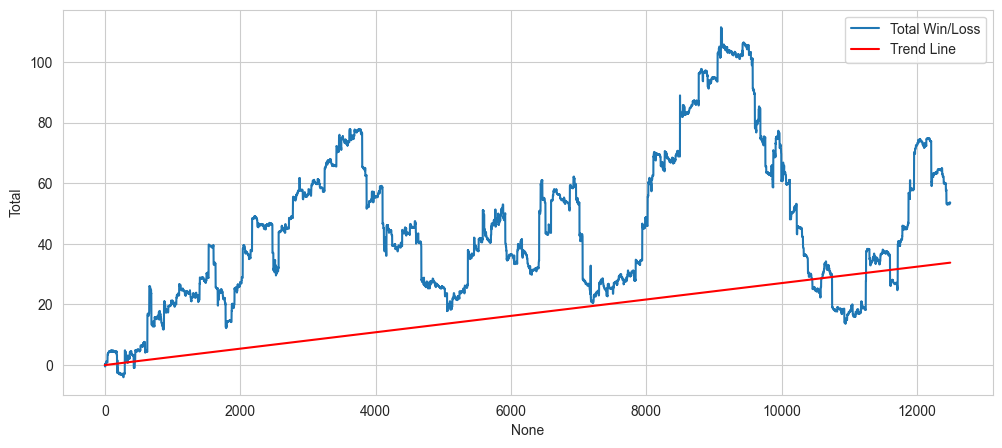

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')
# Enable inline plotting in Jupyter Notebook
%matplotlib inline 

# Calculate the regression line
x = np.arange(len(df))
y = df['Total'].values
coefficients = np.polyfit(x, y, 1)
trendline = np.polyval(coefficients, x)

# Adjust the trendline to start at 0
trendline = trendline - trendline[0]

plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x=df.index, y='Total', label='Total Win/Loss')
plt.plot(df.index, trendline, label='Trend Line', color='red')

plt.legend()
plt.show()

* Calculate the win rate in bb/100 hands

In [63]:
win_rate = round(float(df.iloc[-1]['Total'] * 10 /100), 1)
print(f"Hero's win rate is {win_rate} bb/100")

Hero's win rate is 5.3 bb/100


---

# Conclusions and Next steps

* We discovered that hero has a win rate of 5.3 bb/100 hands. This fulfills the **requirement 1**.
* We will use this data to pre-train re-inforcement model agents in the next notebook.